# Semantic Analysis of Titles
Semantic analysis and clustering of objects in the Wellcome Collection.

## Part 1: Data Extraction

The full metadata on all of the works in the Wellcome Collection is too large to fit into memory: the file is 13 GB. Thus, in order to process the data, we need to:
1. Download the full metadata on all the works on the collection
2. Extract the important aspects (title, subjects, author, languages)
3. Store those aspects in their own dataframe.


In [2]:
from pathlib import Path
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from umap import UMAP
import gzip
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import requests

/home/cfoye/.pyenv/versions/impresso/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
#https://stackoverflow.com/questions/51937381/increase-dpi-of-plt-show#
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
# Download the Names of the Works in the Wellcome Collection
# https://developers.wellcomecollection.org/docs/examples/extracting-features-from-text
import shutil

snapshot_url = "https://data.wellcomecollection.org/catalogue/v2/works.json.gz"

data_dir = Path("../../data").resolve()
data_dir.mkdir(exist_ok=True)

file_name = Path(snapshot_url).parts[-1]
zipped_path = data_dir / file_name
unzipped_path = zipped_path.with_suffix("")


if not unzipped_path.exists():
    if not zipped_path.exists():
        r = requests.get(snapshot_url, stream=True)
        download_progress_bar = tqdm(
            unit="B",
            total=int(r.headers["Content-Length"]),
            desc=f"downloading {file_name}",
        )
        with open(zipped_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    download_progress_bar.update(len(chunk))

    with gzip.open(zipped_path, "rb") as f_in:
        with open(unzipped_path, "wb") as f_out:
            unzip_progress_bar = tqdm(
                unit="B",
                total=zipped_path.stat().st_size,
                desc=f"unzipping {file_name}",
            )
            while True:
                chunk = f_in.read(1024)
                if not chunk:
                    break
                f_out.write(chunk)
                unzip_progress_bar.update(len(chunk))


In [6]:
# Opening the entire archive won't fit into memory: read 1 line at a time

with open(unzipped_path, "r", encoding="utf-8") as f:
    for line in f:
        record = json.loads(line)
        break

record['title']

'Created from animals : the moral implications of Darwinism / James Rachels.'

In [4]:
# Count total number of objects
total_object_count = 0
with open(unzipped_path, "r", encoding="utf-8") as f:
    for line in f:
        total_object_count += 1

print(f"Total Objects: {total_object_count}")

Total Objects: 1166522


In [7]:
record.keys()

dict_keys(['succeededBy', 'production', 'physicalDescription', 'subjects', 'items', 'designation', 'workType', 'identifiers', 'formerFrequency', 'alternativeTitles', 'id', 'languages', 'precededBy', 'partOf', 'genres', 'notes', 'holdings', 'title', 'type', 'contributors', 'images', 'availabilities', 'parts'])

In [23]:
# Store only the important aspects

titles = []
subjects = []
languages = []

with open(unzipped_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Processing records"):
        record = json.loads(line)

        # Extract title
        title = record.get("title", None)

        # Extract subject labels
        subj_list = record.get("subjects", [])
        subj_labels = [s.get('label') for s in subj_list if 'label' in s]

        # Extract languages (handle if they're dicts or strings)
        lang_list = record.get("languages", [])
        lang_labels = []
        for lang in lang_list:
            if isinstance(lang, dict) and 'label' in lang:
                lang_labels.append(lang['label'])
            elif isinstance(lang, str):
                lang_labels.append(lang)

        titles.append(title)
        subjects.append(subj_labels)
        languages.append(lang_labels)

# Create DataFrame
df = pd.DataFrame({
    'title': titles,
    'subjects': subjects,
    'languages': languages
})

Processing records: 1166522it [01:58, 9804.35it/s] 


In [32]:
df['author'] = df['title'].apply(lambda row: row.rsplit('/', 1)[1] if len(row.rsplit('/', 1)) > 1 else None)
df['title_only'] = df['title'].apply(lambda row: row.rsplit('/', 1)[0] if len(row.rsplit('/', 1)) > 1 else row)

In [36]:
df

,title,subjects,languages,author,title_only
0,Created from animals : the moral implications ...,[Biological Evolution - ethics],[English],James Rachels.,Created from animals : the moral implications ...
1,Reproductive biology of the great apes : compa...,"[Apes - Reproduction, Mammals - Reproduction, ...",[English],edited by Charles E. Graham.,Reproductive biology of the great apes : compa...
2,"Arminius, beschermer der Duytsche vryheid. Tre...",[],[Dutch],None,"Arminius, beschermer der Duytsche vryheid. Tre..."
3,Science in India / Arun Kumar Biswas.,"[Science - history, India]",[English],Arun Kumar Biswas.,Science in India
4,Adolf Gottstein (1857-1941) und die Hygiene in...,"[19th century, Public Health - history, Berlin...",[German],P. Schneck.,Adolf Gottstein (1857-1941) und die Hygiene in...
...,...,...,...,...,...
1166517,[Wellcome MS Persian 417].,[],[Persian],None,[Wellcome MS Persian 417].
1166518,[Wellcome MS Persian 232].,[],[Persian],None,[Wellcome MS Persian 232].
1166519,Correspondence concerning appeals and conflict...,[],[],None,Correspondence concerning appeals and conflict...
1166520,Correspondence concerning appeals and conflict...,[],[],None,Correspondence concerning appeals and conflict...


In [35]:
df.to_feather("../../data/works_abridged_df.feather")

# Part 2: Semantic Analysis and Embeddings

After extracting the necessary information for Embeddings on our dataset, we now need to create embeddings for the titles. We can do this using a free service like [Hugging Face Embeddings](https://huggingface.co/blog/getting-started-with-embeddings). We can then visualize those embeddings using tools like TF's Embedding Projector.

In [82]:
df.languages.value_counts()

languages
[English]                              501570
[]                                     428846
[French]                                55493
[German]                                47721
[Latin]                                 45067
                                        ...  
[Slovak, Hungarian]                         1
[English, Danish, French]                   1
[German, Chinese, Japanese, Korean]         1
[English, Italian, French, Spanish]         1
[Amharic, Ethiopic]                         1
Name: count, Length: 1932, dtype: int64

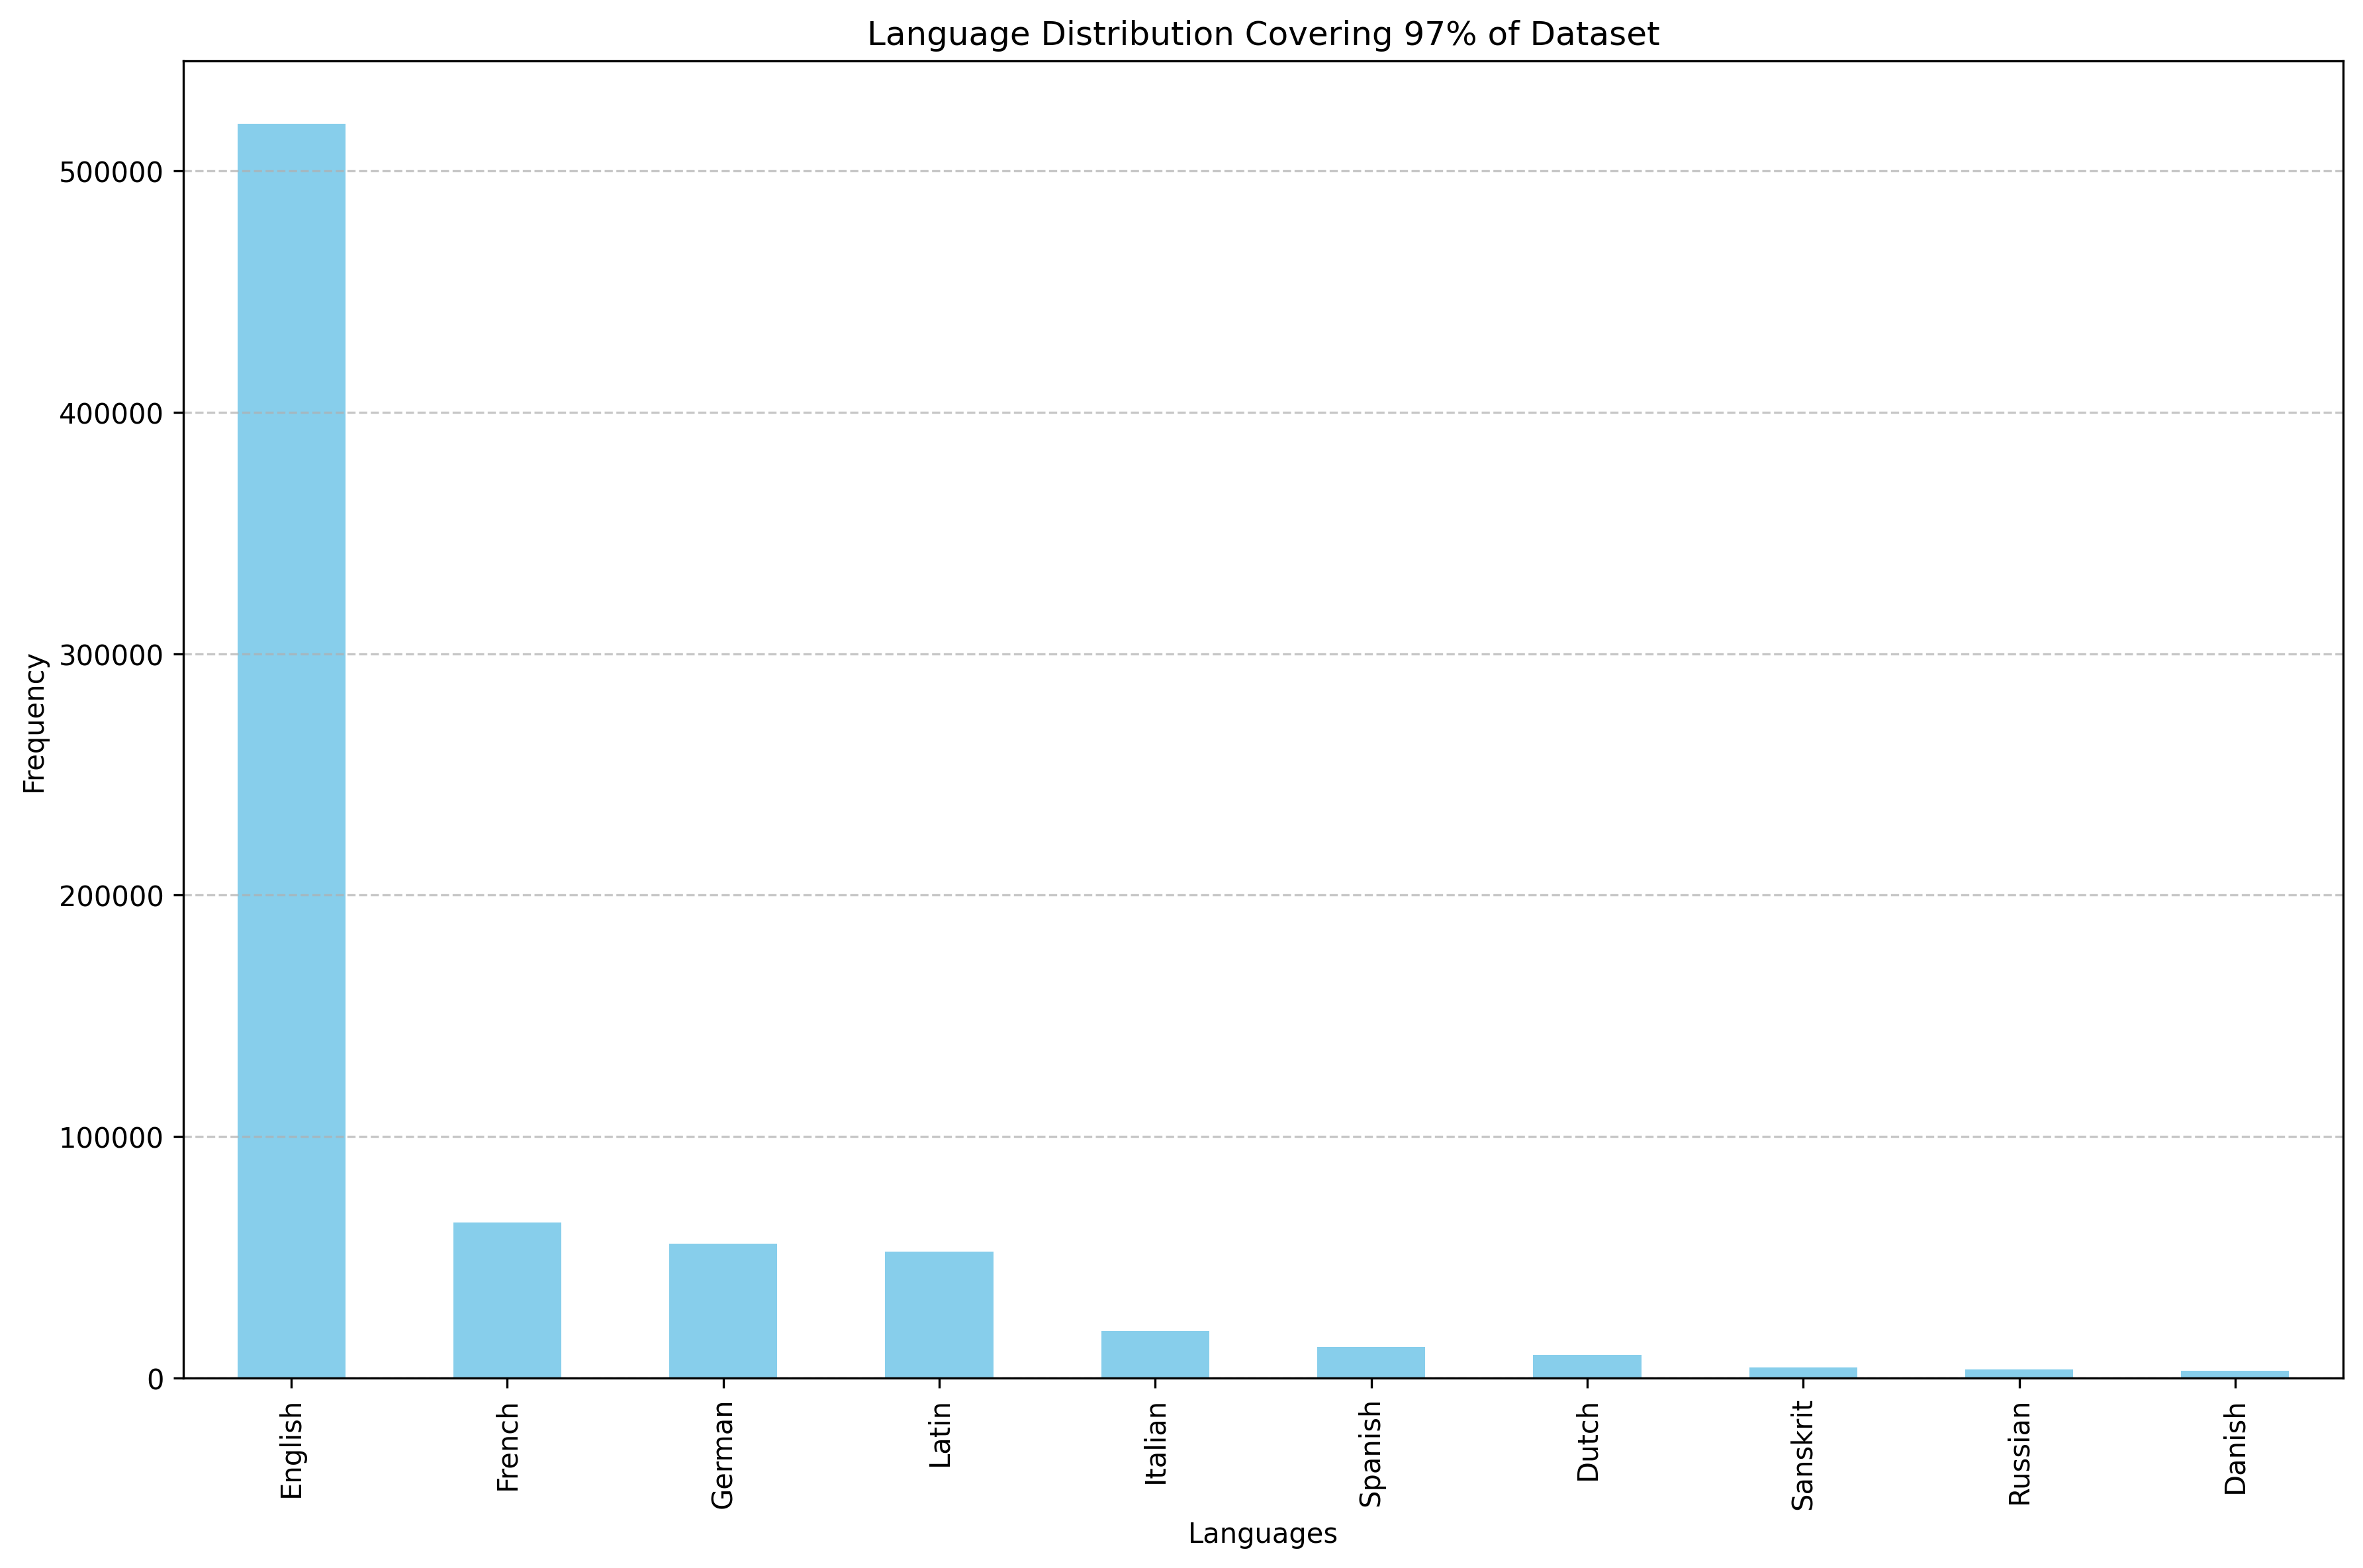

In [90]:
df_exploded = df.explode('languages')

# Calculate the frequency of each language
language_counts = df_exploded['languages'].value_counts()

# Compute the cumulative percentage
cumulative_percentage = language_counts.cumsum() / language_counts.sum() * 100

# Filter languages that contribute to the top 95% cumulative percentage
top_95_languages = cumulative_percentage[cumulative_percentage <= 97].index
top_95_counts = language_counts.loc[top_95_languages]

# Plotting
plt.figure(figsize=(12, 8))
top_95_counts.plot(kind='bar', color='skyblue')
plt.title('Language Distribution Covering 97% of Dataset')
plt.xlabel('Languages')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Get Embeddings using this tutorial: https://huggingface.co/blog/getting-started-with-embeddings

In [ ]:
import os

# model_id = "sentence-transformers/all-MiniLM-L6-v2"
model_id = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
# model_id = "sentence-transformers/distiluse-base-multilingual-cased-v2"
hf_token = os.getenv("HUGGINGFACE_API_KEY")
if hf_token is None:
    raise EnvironmentError("Missing required environment variable: HUGGINGFACE_API_KEY")

In [66]:
api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
headers = {"Authorization": f"Bearer {hf_token}"}

In [44]:
def query(texts):
    response = requests.post(api_url, headers=headers, json={"inputs": texts, "options":{"wait_for_model":True}})
    return response.json()

In [60]:
texts = list(df.title_only.array)

In [78]:
import numpy as np

def compute_embeddings_in_batches(texts, batch_size=10000):
    embeddings = []
    num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)

    for i in tqdm(range(num_batches), desc="Computing embeddings", unit="batch"):
        batch_texts = texts[i * batch_size:(i + 1) * batch_size]
        batch_embeddings = query(batch_texts)
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)


In [79]:
embeddings = compute_embeddings_in_batches(texts)

Computing embeddings:   1%|          | 1/117 [01:18<2:31:42, 78.47s/batch]


KeyboardInterrupt: 

In [ ]:
df.to_feather("../../data/works_abridged_embeddings-df.feather")